# Opcode Sequence을 사용한 machineLearning 기반 malware detection Model
- dataset: https://github.com/iosifache/DikeDataset
- Accuracy: 0.9852602487333026

# 필요 package 설치

In [1]:
!pip install pefile
!pip install capstone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 필요 package Import

In [26]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score, f1_score

# Data load
- OpcodeExtracter.ipynb 파일을 통해 pickle 형태로 1차로 데이터를 추출하고 테스트하는 것을 추천 드립니다.
- 악성코드 및 양성코드는 보안 관계상 올리지 못하였고, 저희가 생성한 Malware과 Benign Opcode dataset이 저장된 pickle 파일들은 용량 관계상 github load를 생략하였습니다.
- 본 모델과 같게 모델을 학습하는 것을 희망한다면, OpcodeExtracter.ipynb 파일을 통해 데이터셋 pickle 파일을 생성하셔서 입력하시면 됩니다.
- Dataset은 DikeDataset과 임의로 크롤링한 gnu file 약 1000개를 사용하였습니다.
- DikeDataset: https://github.com/iosifache/DikeDataset

## Malware Dataset Load

In [3]:
with open('/content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/files/opcode database/MalwareOpcodes.p', 'rb') as file:
    MalwareDataset = pickle.load(file)

## Benign Dataset Load

### Dike dataset

In [4]:
with open('/content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/files/opcode database/BenignOpcodes.p', 'rb') as file:
    BenignDataset = pickle.load(file)

### GnuWin Packages(List 형태)

In [5]:
with open('/content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/files/opcode database/BenignOpcodes2.p', 'rb') as file:
    BenignDataset2 = pickle.load(file)

print(list(BenignDataset2.values())[0])

['push', 'mov', 'sub', 'mov', 'call', 'call', 'mov', 'xor', 'pop', 'ret', 'mov', 'push', 'mov', 'sub', 'mov', 'call', 'call', 'mov', 'xor', 'pop', 'ret', 'mov', 'push', 'mov', 'sub', 'mov', 'mov', 'call', 'mov', 'pop', 'ret', 'lea', 'lea', 'push', 'mov', 'sub', 'mov', 'mov', 'call', 'mov', 'pop', 'ret', 'lea', 'lea', 'push', 'mov', 'push', 'sub', 'mov', 'call', 'sub', 'call', 'mov', 'mov', 'lea', 'mov', 'mov', 'mov', 'lea', 'mov', 'mov', 'call', 'mov', 'test', 'je', 'mov', 'mov', 'test', 'je', 'mov', 'mov', 'mov', 'call', 'mov', 'cmp', 'je', 'mov', 'mov', 'mov', 'mov', 'call', 'mov', 'cmp', 'je', 'mov', 'mov', 'mov', 'mov', 'call', 'call', 'mov', 'mov', 'call', 'call', 'mov', 'mov', 'mov', 'mov', 'mov', 'mov', 'call', 'mov', 'call', 'mov', 'call', 'lea', 'push', 'mov', 'sub', 'mov', 'mov', 'xor', 'mov', 'xor', 'mov', 'mov', 'cmp', 'ja', 'cmp', 'jae', 'cmp', 'je', 'mov', 'mov', 'mov', 'mov', 'pop', 'ret', 'mov', 'mov', 'call', 'cmp', 'je', 'test', 'je', 'mov', 'lea', 'lea', 'call', 'mov

## opcode 리스트 로드
- file 폴더에 있는 opcodesList.txt 파일을 filePath로 설정하시면 됩니다.

In [6]:
filePath = '/content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/files/opcode database/opcodesList.txt'
with open(filePath, 'rb') as lf:
    opcodes = pickle.load(lf)
    print(opcodes)

['aaa', 'aad', 'aam', 'aas', 'adc', 'add', 'and', 'call', 'cbw', 'clc', 'cld', 'cli', 'cmc', 'cmp', 'cmpsb', 'cmpsw', 'cwd', 'daa', 'das', 'dec', 'div', 'esc', 'hlt', 'idiv', 'imul', 'in', 'inc', 'int', 'into', 'iret', 'jcc', 'ja', 'jae', 'jb', 'jbe', 'jc', 'je', 'jg', 'jge', 'jl', 'jle', 'jnle', 'jno', 'jnp', 'jns', 'jnz', 'jo', 'jp', 'jpe', 'jpo', 'js', 'jz', 'jcxz', 'jmp', 'lahf', 'lds', 'lea', 'les', 'lock', 'lodsb', 'lodsw', 'loop', 'loope', 'loopne', 'loopnz', 'loopz', 'loopx', 'mov', 'movsb', 'movsw', 'mul', 'neg', 'nop', 'not', 'or', 'out', 'pop', 'popf', 'push', 'pushf', 'rcl', 'rcr', 'repxx', 'rep', 'repe', 'repne', 'repnz', 'repz', 'ret', 'retn', 'retf', 'rol', 'ror', 'sahf', 'sal', 'sar', 'sbb', 'scasb', 'scasw', 'shl', 'shr', 'stc', 'std', 'sti', 'stosb', 'stosw', 'sub', 'test', 'wait', 'xchg', 'xlat', 'xor']


In [7]:
opcodeDict = {}
for i in range(len(opcodes)):
    opcodeDict.setdefault(opcodes[i], i)

print(opcodeDict)

{'aaa': 0, 'aad': 1, 'aam': 2, 'aas': 3, 'adc': 4, 'add': 5, 'and': 6, 'call': 7, 'cbw': 8, 'clc': 9, 'cld': 10, 'cli': 11, 'cmc': 12, 'cmp': 13, 'cmpsb': 14, 'cmpsw': 15, 'cwd': 16, 'daa': 17, 'das': 18, 'dec': 19, 'div': 20, 'esc': 21, 'hlt': 22, 'idiv': 23, 'imul': 24, 'in': 25, 'inc': 26, 'int': 27, 'into': 28, 'iret': 29, 'jcc': 30, 'ja': 31, 'jae': 32, 'jb': 33, 'jbe': 34, 'jc': 35, 'je': 36, 'jg': 37, 'jge': 38, 'jl': 39, 'jle': 40, 'jnle': 41, 'jno': 42, 'jnp': 43, 'jns': 44, 'jnz': 45, 'jo': 46, 'jp': 47, 'jpe': 48, 'jpo': 49, 'js': 50, 'jz': 51, 'jcxz': 52, 'jmp': 53, 'lahf': 54, 'lds': 55, 'lea': 56, 'les': 57, 'lock': 58, 'lodsb': 59, 'lodsw': 60, 'loop': 61, 'loope': 62, 'loopne': 63, 'loopnz': 64, 'loopz': 65, 'loopx': 66, 'mov': 67, 'movsb': 68, 'movsw': 69, 'mul': 70, 'neg': 71, 'nop': 72, 'not': 73, 'or': 74, 'out': 75, 'pop': 76, 'popf': 77, 'push': 78, 'pushf': 79, 'rcl': 80, 'rcr': 81, 'repxx': 82, 'rep': 83, 'repe': 84, 'repne': 85, 'repnz': 86, 'repz': 87, 'ret': 

# DataFrame 생성

## Malware DataFrame

In [8]:
nameList = list(MalwareDataset.keys())
opcodeList = list(MalwareDataset.values())
opcodeFrequencyList = []
LenList = []

for opList in opcodeList:
    tempList = [0 for i in range(len(opcodes))]
    tempLen = 0
    for op in opList:
        tempList[opcodeDict[op]] += 1
        tempLen += 1
    
    opcodeFrequencyList.append(tempList)
    LenList.append(tempLen)

MalwareDict = {'Name' : nameList,
           'opcodeFrequency' : opcodeFrequencyList,
           'Len' : LenList,
           'class' : [1 for i in range(len(opcodeList))]}

MalwareDf = pd.DataFrame.from_dict(MalwareDict)

- name: 파일의 이름
- opcodeFrequency: 특정 번호와 매칭된 opcode가 하나의 PeFIle에서 출현한 횟수
- len: PEFILE 내 전체 opcode들의 개수
- class: 라벨, (1: malware, 0: Benign)

In [9]:
MalwareDf

,Name,opcodeFrequency,Len,class
0,0004b6ce277aa1a259359ee0400bf7cb3f2aafdeeae291...,"[0, 0, 0, 0, 4, 527, 81, 193, 0, 2, 9, 0, 0, 2...",4129,1
1,00145e98e0394c0ad3f0e1fc801676f426ed657d064076...,"[0, 1, 1, 4, 4, 1502, 141, 284, 0, 0, 9, 0, 0,...",7285,1
2,00255bab3a31b108a9de13b0944a50b5fa866dc53c139c...,"[0, 0, 1, 0, 86, 1159, 128, 111, 0, 3, 0, 1, 0...",5209,1
3,002d72a4eb8f8e2aaea0efd51128afaf0d291b9483dc68...,"[3, 0, 0, 0, 1, 893, 180, 658, 0, 0, 9, 0, 0, ...",9730,1
4,004843d2d85eb96ccd4e5e3dc7f54ed114753bc589af55...,"[191, 232, 215, 206, 1417, 2021, 1519, 433, 1,...",50979,1
...,...,...,...,...
8634,ffda06ca06f789fbd955b037808d4d34d8b4c63924c927...,"[0, 0, 0, 4, 4, 1502, 141, 284, 0, 0, 9, 0, 0,...",7285,1
8635,ffddd100d6ca8119d2aa181ff85626c5826e19e39b9c67...,"[0, 0, 0, 0, 0, 68, 2, 37, 0, 0, 0, 0, 0, 22, ...",933,1
8636,ffe363df14867182a7df4c9284678a9bda0d34826466ac...,"[54, 73, 68, 68, 421, 12769, 421, 704, 1, 87, ...",34042,1
8637,ffe51dfef7f6357211f4e3b022b33fb43f4dc9fce3faf0...,"[4, 4, 6, 1, 148, 7387, 1927, 13346, 0, 2, 15,...",136354,1


## Benign DataFrame

In [10]:
nameList = list(BenignDataset.keys())
opcodeList = list(BenignDataset.values())
opcodeFrequencyList = []
LenList = []

for opList in opcodeList:
    tempList = [0 for i in range(len(opcodes))]
    tempLen = 0
    for op in opList:
        tempList[opcodeDict[op]] += 1
        tempLen += 1
    
    opcodeFrequencyList.append(tempList)
    LenList.append(tempLen)

BenignDict = {'Name' : nameList,
           'opcodeFrequency' : opcodeFrequencyList,
           'Len' : LenList,
           'class' : [0 for i in range(len(opcodeList))]}

BenignDf = pd.DataFrame.from_dict(BenignDict)

In [11]:
BenignDf

,Name,opcodeFrequency,Len,class
0,002ce0d28ec990aadbbc89df457189de37d8adaadc9c08...,"[0, 0, 0, 0, 1, 2536, 823, 5818, 0, 0, 0, 0, 0...",99752,0
1,003851675800dc05cdac1baa84cab8f68534b244906d97...,"[0, 0, 1, 0, 0, 83, 7, 386, 0, 0, 0, 0, 0, 96,...",4074,0
2,00eea85752664955047caad7d6280bc7bf1ab91c61eb9a...,"[0, 0, 1, 0, 0, 137, 8, 631, 0, 0, 0, 0, 0, 17...",7549,0
3,0111bddac92a792c7b2ee3ab77642c33df0e01afe737b0...,"[0, 0, 0, 0, 0, 305, 88, 1111, 0, 0, 3, 0, 0, ...",11917,0
4,016584e586de67b725ac1e3974fcca320bf81c8c489ebb...,"[0, 0, 0, 0, 19, 1008, 169, 948, 0, 0, 13, 0, ...",15636,0
...,...,...,...,...
957,ff3a27c79a9938205bb158f87c020fa24a42612c8b6b0c...,"[0, 0, 0, 0, 16, 154, 27, 780, 0, 0, 0, 0, 0, ...",7564,0
958,ff6d6d846bb0ef538a95836a52e6187c855cbf93e2fce3...,"[0, 0, 1, 0, 0, 228, 9, 1015, 0, 0, 0, 0, 0, 1...",10381,0
959,ff9ef3f71807789ab7387c00020b61f7c7ffdcbd7f55d5...,"[0, 1, 0, 4, 16, 4256, 612, 559, 0, 2, 2, 0, 0...",15521,0
960,ffb860e143e71b639ce6e78afc0a4e120714fcffbbc811...,"[0, 5, 4, 2, 177, 18100, 1015, 38665, 2, 0, 0,...",382920,0


In [12]:
nameList = list(BenignDataset2.keys())
opcodeList = list(BenignDataset2.values())
opcodeFrequencyList = []
LenList = []

for opList in opcodeList:
    tempList = [0 for i in range(len(opcodes))]
    tempLen = 0
    for op in opList:
        tempList[opcodeDict[op]] += 1
        tempLen += 1
    
    opcodeFrequencyList.append(tempList)
    LenList.append(tempLen)

BenignDict2 = {'Name' : nameList,
           'opcodeFrequency' : opcodeFrequencyList,
           'Len' : LenList,
           'class' : [0 for i in range(len(opcodeList))]}

BenignDf2 = pd.DataFrame.from_dict(BenignDict2)

In [13]:
BenignDf2.head()

,Name,opcodeFrequency,Len,class
0,411toppm.exe,"[0, 0, 0, 0, 0, 51, 22, 109, 0, 0, 0, 0, 0, 67...",1480,0
1,a2ps-4.14-1-setup.exe,"[2, 1, 29, 1, 37, 1238, 124, 916, 0, 5, 5, 1, ...",13499,0
2,a2ps-4.14-1-src-setup.exe,"[2, 1, 29, 1, 37, 1238, 124, 916, 0, 5, 5, 1, ...",13499,0
3,a2ps.exe,"[1, 0, 0, 0, 7, 4743, 259, 4685, 0, 0, 344, 0,...",72897,0
4,abs.exe,"[0, 0, 0, 0, 0, 152, 4, 41, 0, 0, 0, 0, 0, 23,...",699,0


## 두 종류의 dataFrame 합체

In [14]:
# dataFrame = pd.concat([MalwareDf[:2000],BenignDf,BenignDf2])
dataFrame = pd.concat([MalwareDf,BenignDf,BenignDf2])

index_=range(len(dataFrame['Len']))
dataFrame['index']=index_
dataFrame.set_index('index', append=True)
dataFrame.set_index('index', inplace=True)

for i in range(len(dataFrame['Len'])):
    if dataFrame['Len'][i] == 0:
        dataFrame.drop([i], inplace=True)

index_=range(len(dataFrame['Len']))
dataFrame['index']=index_
dataFrame.set_index('index', append=True)
dataFrame.set_index('index', inplace=True)

dataFrame

,Name,opcodeFrequency,Len,class
index,,,,
0,0004b6ce277aa1a259359ee0400bf7cb3f2aafdeeae291...,"[0, 0, 0, 0, 4, 527, 81, 193, 0, 2, 9, 0, 0, 2...",4129,1
1,00145e98e0394c0ad3f0e1fc801676f426ed657d064076...,"[0, 1, 1, 4, 4, 1502, 141, 284, 0, 0, 9, 0, 0,...",7285,1
2,00255bab3a31b108a9de13b0944a50b5fa866dc53c139c...,"[0, 0, 1, 0, 86, 1159, 128, 111, 0, 3, 0, 1, 0...",5209,1
3,002d72a4eb8f8e2aaea0efd51128afaf0d291b9483dc68...,"[3, 0, 0, 0, 1, 893, 180, 658, 0, 0, 9, 0, 0, ...",9730,1
4,004843d2d85eb96ccd4e5e3dc7f54ed114753bc589af55...,"[191, 232, 215, 206, 1417, 2021, 1519, 433, 1,...",50979,1
...,...,...,...,...
10847,zipnote.exe,"[0, 0, 0, 0, 39, 504, 67, 1516, 0, 0, 6, 0, 0,...",17261,0
10848,zipsplit.exe,"[0, 0, 0, 0, 70, 538, 71, 1499, 0, 0, 6, 0, 0,...",17779,0
10849,zlib-1.2.3-src.exe,"[2, 1, 28, 1, 42, 1201, 128, 892, 0, 5, 4, 1, ...",13151,0


# 종속변수와 독립변수 생성

In [15]:
dict_list = [[] for o in opcodes]

for i in range(len(dataFrame)):
    for j in range(len(opcodes)):
        dict_list[j].append(dataFrame['opcodeFrequency'][i][j])

dictionary = dict(zip(opcodes, dict_list))

In [16]:
XDf = pd.DataFrame.from_dict(dictionary)
XDf.head()

,aaa,aad,aam,aas,adc,add,and,call,cbw,clc,...,std,sti,stosb,stosw,sub,test,wait,xchg,xlat,xor
0,0,0,0,0,4,527,81,193,0,2,...,8,0,3,0,56,137,0,1,0,80
1,0,1,1,4,4,1502,141,284,0,0,...,8,0,3,0,95,211,1,0,0,124
2,0,0,1,0,86,1159,128,111,0,3,...,1,1,2,0,419,38,0,25,0,87
3,3,0,0,0,1,893,180,658,0,0,...,8,0,3,0,144,302,1,4,0,261
4,191,232,215,206,1417,2021,1519,433,1,219,...,200,231,217,2,1643,1027,197,1901,0,1979


In [17]:
X = XDf
y = dataFrame['class']

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42) # 학습데이터와 평가데이터의 비율을 8:2 로 분할| 
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 개수 확인

(8681, 112) (2171, 112) (8681,) (2171,)


# XGBoost 설계 및 학습

In [40]:
clf = XGBClassifier(booster = 'gbtree', importance_type = 'gain')
clf.fit(train_x,train_y)

predict2 = clf.predict(test_x)
print('Accuracy: ' + str(accuracy_score(test_y,predict2)))

Accuracy: 0.9852602487333026


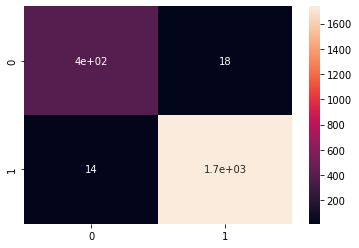

In [32]:
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(test_y, predict2), columns=[0, 1], index=[0, 1])
sns.heatmap(cm, annot=True)

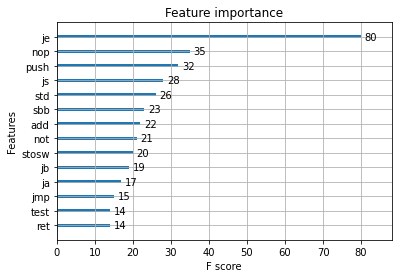

In [33]:
plot_importance(clf, max_num_features=14)

plt.show()

# 모델 저장

In [41]:
# 파일명
filename = 'XGBClassifier.model'

# 모델 저장
pickle.dump(clf, open(filename, 'wb'))

# 모델 불러오기
clf = pickle.load(open(filename, 'rb'))

# Sample file Test
- Test를 위해 utils 폴더 내부의 utils.py 파일을 활용한다.

## utils.py 파일, sample 파일이 있는 폴더로 위치 변경

In [21]:
%cd /content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/휴지통/test

/content/drive/MyDrive/Capstone Design Project + 한이음 과정/code/휴지통/test


## utils.py 파일 로드

In [22]:
from utils import *

## MalwareDetectionFunction을 통한 Malware 탐지
- 양성 샘플 파일이 양성으로 결과가 나오는지 확인
- return 1: 악성코드, return 0: 양성코드

In [24]:
# 머신러닝 모델(XGBClassifier)을 바탕으로 해당 파일이 악성코드인지를 알려주는 함수
# return 1: 악성코드, return 0: 양성코드
def MalwareDetectionFunction(model, fileName):
    try:
        #parse exe file
        exe = pefile.PE(fileName)
        #call the function we created earlier
        sampleOpcodeList = ExtractPefileOpcodes(opcodes, exe)
    except:
        print('Error File')

    sampleFrequencyList = [0 for i in range(len(opcodes))]
    for op in sampleOpcodeList:
        sampleFrequencyList[opcodeDict[op]] += 1

    dict_list = [[] for o in opcodes]

    for i in range(len(opcodes)):
        dict_list[i].append(sampleFrequencyList[i])

    dictionary = dict(zip(opcodes, dict_list))
    sampleDf = pd.DataFrame.from_dict(dictionary)
    sampleDf.head()

    if 1 == clf.predict(sampleDf)[0]:
        return 1

    else:
        return 0

- 결과가 0으로 양성파일을 탐지한 것읋 확인할 수 있다.

In [43]:
fileName = '3f3fe9ecad7f30fc80cdfb678d7ca27a30d0575a73818746e98be9170d3be348.exe'

MalwareDetectionFunction(clf, fileName)

0